<h1><center> TEXT MINING - PORTUGUESE AUTHORS</center></h1>
<h3><center> In this notebook we will create a model that given a text it predicts which author wrote it. </center></h3> 
<h5><center> Francisco Ramalho </center></h5> 
<h5><center> April 2021 </center></h5> 

--------------

<a id="section01">
    
### Introduction

There are 63 text files each one corresponding to a text written by a certain author. The author of the text is not identified in the text file itself, but the files are organized in a structure that each author’s text is in a dedicated folder:

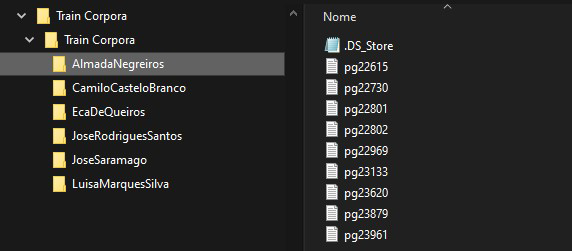

The language of the texts is Portuguese.
In some folders, there is also a file called “.DS_Store” that will not be used to create the model since it does not have any relevant information.

The objective of our project is to create a classification model that when given a text it will be able to predict which of the 6 authors above wrote it.

-------------

<a id="section02">

### Corpora description

In order to build our corpus we need to gather the corpora in each text file to a single dataframe where we can process it. Also, we need to label each corpora with the author it corresponds to. The dataframe created has two columns: “Author” and “Text” and 63 rows.

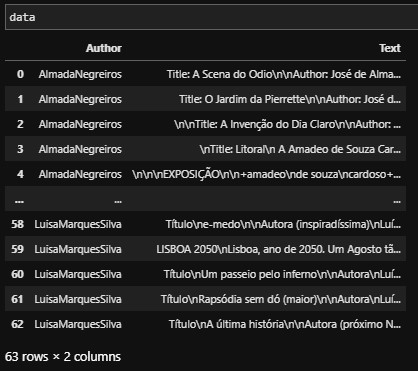

The distribution of texts by author is the following:

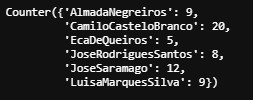

-----------------------------

<a id="section03">
    
### Evaluation Criteria

Since the objective is to predict the text’s author, we are mainly interested in the number of correct predictions. In this context, there is no substantial difference between false negatives and false positives. Also, we can consider the distribution of texts by authors to be well balanced as we do not have any author that “dominates” the dataset.
Based on these facts we consider the accuracy metric to be the best metric to evaluate model performance.

-------------------------

##### Important note: please be aware that the GridSearch on the Multilayer Perceptron - ANN section takes nearly 1-hour to run

<h3 style='color:#5F6A6E' > Index:</h3>

[1. Introduction](#section01) <br>
[2. Corpora description](#section02) <br>
[3. Evaluation Criteria](#section03) <br>
[4. Loading Data](#section04) <br>
[5. Baseline Model](#section05) <br>
[6. Train/Test split](#section06) <br>
[7. Feature engineering: binary Bag of Words](#section07) <br>
[8. KNN](#section08) <br>
[9. Evaluate Baseline Model](#section09) <br>
[10. Improving Baseline Model](#section010) <br>
[11. Attempt 1: Testing TFIDF vectorizer](#section011) <br>
[12. Attempt 2: Testing KNN with diferents k](#section12) <br>
[13. Attempt 3: Naive Bayes](#section13) <br>
[14. Attempt 4: Logistic Regression](#section14) <br>
[15. Attempt 5: Multilayer Perceptron - ANN](#section15) <br>
[16. Final Model](#section16) <br>
[17. Conclusion](#section17) <br>

<a id="section04">
<h3 style='color:#5F6A6E' > 4. Loading Data</h3>

In [1]:
import os
import pandas as pd
data=pd.DataFrame(columns=['Author', 'Text'])
data

,Author,Text


In [2]:
mypath=r'C:\temp\Train Corpora'
authors=os.listdir(mypath)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for author in authors:
    path=mypath+'\\'+author
    files=os.listdir(path)
    for file in files:
        filename=path+'\\'+file
        if filename.endswith('.txt'):
            with open(filename, 'r', encoding='utf-8') as abc:
                text = abc.read()
            new_row=pd.Series({"Author": author,"Text":text})
            data=data.append(new_row, ignore_index=True)

In [4]:
authors

['AlmadaNegreiros',
 'CamiloCasteloBranco',
 'EcaDeQueiros',
 'JoseRodriguesSantos',
 'JoseSaramago',
 'LuisaMarquesSilva']

In [5]:
data

,Author,Text
0,AlmadaNegreiros,Title: A Scena do Odio\n\nAuthor: José de Alma...
1,AlmadaNegreiros,Title: O Jardim da Pierrette\n\nAuthor: José d...
2,AlmadaNegreiros,\n\nTitle: A Invenção do Dia Claro\n\nAuthor: ...
3,AlmadaNegreiros,\nTitle: Litoral\n A Amadeo de Souza Car...
4,AlmadaNegreiros,\n\n\nEXPOSIÇÃO\n\n+amadeo\nde souza\ncardoso+...
...,...,...
58,LuisaMarquesSilva,Título\ne-medo\n\nAutora (inspiradíssima)\nLuí...
59,LuisaMarquesSilva,"LISBOA 2050\nLisboa, ano de 2050. Um Agosto tã..."
60,LuisaMarquesSilva,Título\nUm passeio pelo inferno\n\nAutora\nLuí...
61,LuisaMarquesSilva,Título\nRapsódia sem dó (maior)\n\nAutora\nLuí...


In [6]:
from collections import Counter
Counter(data['Author'])

Counter({'AlmadaNegreiros': 9,
         'CamiloCasteloBranco': 20,
         'EcaDeQueiros': 5,
         'JoseRodriguesSantos': 8,
         'JoseSaramago': 12,
         'LuisaMarquesSilva': 9})

<a id="section05">
<h3 style='color:#5F6A6E' > 5. Baseline Model</h3>

Our first model attempt will serve as a baseline and consists on the following:

    1. Preprocessing methods: lowercasing; removing punctuation, accents, numerical characters and stopwords <br>
    2. Feature engineering: binary Bag of Words <br>
    3. Model: K-Nearest-Neighbors (KNN) with k=5 <br>
    4. Evaluation criteria: Accuracy## NLP Preprocessing

In [7]:
from tqdm import tqdm
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stemmer = SnowballStemmer('portuguese')
lemma = WordNetLemmatizer()
from nltk.corpus import wordnet
from nltk.corpus import stopwords
stop = set(stopwords.words('portuguese'))
import unidecode

In [8]:
def clean(text_list, lemmatize, stemmer):
    
    updates = []
    
    for j in tqdm(text_list):
        
        text = j
        
        if type(text)==bool:
            text=str(text)
        #LOWERCASE TEXT
        text = text.lower()
       
        #REMOVE PUNCTUATION
        text=re.sub("\W"," ",text)
    
        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
        #REMOVE ACCENTS
        text = unidecode.unidecode(text)
               
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
 
        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
        #Lemmatize
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        #Stemming
        if stemmer:
            text = " ".join(stemmer.stem(word) for word in text.split())
               
        updates.append(text)
        
    return updates

In [9]:
updates = clean(data['Text'], lemmatize = False, stemmer = False)

100%|██████████| 63/63 [00:12<00:00,  5.24it/s]


In [10]:
len(updates)

63

In [11]:
updates[4]

'exposicao amadeo souza cardoso liga naval lisboa portugal existe unica opiniao sobre arte abrange tao colossal maioria receio ella impere esmagamento opiniao ex mo sr dr jose figueiredo gago governo porque snr opiniao snr igualha resto portugal resto portugal senhor materia opiniao mesma igualha dia senhor grisalho disse meia hora conhecimentos sobre arte acabou meia hora descobri conhecimentos senhor grisalho sobre arte mesmos ex mo senhor dr jose figueiredo usava pedir tostao pensa leitor faco anedocta antes verdade triste furia incompetencia portugal participa guerra europeia horror caros compatriotas deduzir experimentalmente todas conquistas descobertas apenas sobrevivido imbecilidade daqui indiferenca espartilhada familia portugueza convalescer beira mar algumas raras energias mal comportadas ainda assomam tona d agua pertencem halucinadamente seculos existem portuguez genialmente seculo xx desce europa condoido patria entrevada dar parto intelligencia indiferenca espartilhada f

In [12]:
words_in_df= ''.join(updates).split()
freq = pd.Series(words_in_df).value_counts()
freq[0:25]

d         12480
disse      7494
ser        7060
la         6819
ainda      6639
bem        5716
onde       5642
sobre      5090
porque     5011
assim      4912
olhos      4908
n          4874
aqui       4824
tudo       4785
agora      4730
homem      4712
casa       4588
tao        4562
elle       4490
entao      4476
ter        4438
tempo      4283
senhor     4153
mulher     4032
dizer      3943
dtype: int64

In [13]:
stop

{'a',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'estamos',
 'estas',
 'estava',
 'estavam',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéramos',
 'estivéssemos',
 'estou',
 'está',
 'estávamos',
 'estão',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fui',
 'fôramos',
 'fôssemos',
 'haja',
 'hajam',
 'hajamos',
 'havemos',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houveram',
 'houverei',
 'houverem',
 'houveremos',
 'houveria',
 'houveriam',
 'houvermos',
 'houverá',
 'houverão',
 'houveríamos',
 'houvesse',


In [14]:
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"Text": list_updated}))

In [15]:
update_df(data, updates)
data

,Author,Text
0,AlmadaNegreiros,title scena odio author jose almada negreiros ...
1,AlmadaNegreiros,title jardim pierrette author jose almada negr...
2,AlmadaNegreiros,title invencao dia claro author jose almada ne...
3,AlmadaNegreiros,title litoral amadeo souza cardozo author jose...
4,AlmadaNegreiros,exposicao amadeo souza cardoso liga naval lisb...
...,...,...
58,LuisaMarquesSilva,titulo medo autora inspiradissima luisa marque...
59,LuisaMarquesSilva,lisboa lisboa ano agosto tao gelado vinte anos...
60,LuisaMarquesSilva,titulo passeio inferno autora luisa marques si...
61,LuisaMarquesSilva,titulo rapsodia maior autora luisa marques sil...


<a id="section06">
<h3 style='color:#5F6A6E' > 6. Train/Test split</h3>

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np
X=data['Text']
y=data['Author']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.33, random_state=100)
X_train=X_train.to_frame()


<a id="section07">
<h3 style='color:#5F6A6E' > 7. Feature engineering: binary Bag of Words</h3>

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
cv = CountVectorizer (binary = True)
X = cv.fit_transform(X_train['Text'])

In [19]:
X.shape

(42, 88205)

<a id="section08">
<h3 style='color:#5F6A6E' > 8. KNN</h3>

<h3 style='color:#5F6A6E' > Train Classifier</h3>

In [20]:
from sklearn.neighbors import KNeighborsClassifier
modelknn = KNeighborsClassifier(n_neighbors = 5, metric='cosine', weights = 'distance')

In [21]:
modelknn.fit(X,y_train)

KNeighborsClassifier(metric='cosine', weights='distance')

<h3 style='color:#5F6A6E' > Predict X_test</h3>

In [22]:
def test_to_df(list_test):
    list_test = clean(list_test, lemmatize=False, stemmer=False)
    return list_test
test_sentences = test_to_df(X_test)

100%|██████████| 21/21 [00:00<00:00, 34.79it/s]


In [23]:
test = cv.transform(test_sentences)
predict=modelknn.predict(test)
predict

array(['JoseSaramago', 'CamiloCasteloBranco', 'LuisaMarquesSilva',
       'CamiloCasteloBranco', 'JoseSaramago', 'LuisaMarquesSilva',
       'JoseSaramago', 'LuisaMarquesSilva', 'JoseSaramago',
       'JoseRodriguesSantos', 'CamiloCasteloBranco',
       'CamiloCasteloBranco', 'CamiloCasteloBranco', 'AlmadaNegreiros',
       'CamiloCasteloBranco', 'JoseSaramago', 'AlmadaNegreiros',
       'EcaDeQueiros', 'CamiloCasteloBranco', 'AlmadaNegreiros',
       'JoseRodriguesSantos'], dtype=object)

In [24]:
y_test

45           JoseSaramago
11    CamiloCasteloBranco
59      LuisaMarquesSilva
23    CamiloCasteloBranco
42           JoseSaramago
61      LuisaMarquesSilva
32           EcaDeQueiros
54      LuisaMarquesSilva
44           JoseSaramago
37    JoseRodriguesSantos
13    CamiloCasteloBranco
17    CamiloCasteloBranco
20    CamiloCasteloBranco
8         AlmadaNegreiros
28    CamiloCasteloBranco
49           JoseSaramago
0         AlmadaNegreiros
29           EcaDeQueiros
25    CamiloCasteloBranco
3         AlmadaNegreiros
41    JoseRodriguesSantos
Name: Author, dtype: object

<a id="section09">
<h3 style='color:#5F6A6E' > 9. Evaluate Baseline Model</h3>

In [25]:
from sklearn.metrics import classification_report
print(classification_report(predict, y_test, target_names = authors))

                     precision    recall  f1-score   support

    AlmadaNegreiros       1.00      1.00      1.00         3
CamiloCasteloBranco       1.00      1.00      1.00         7
       EcaDeQueiros       0.50      1.00      0.67         1
JoseRodriguesSantos       1.00      1.00      1.00         2
       JoseSaramago       1.00      0.80      0.89         5
  LuisaMarquesSilva       1.00      1.00      1.00         3

           accuracy                           0.95        21
          macro avg       0.92      0.97      0.93        21
       weighted avg       0.98      0.95      0.96        21



C:\Users\Francisco\AppData\Local\Temp\ipykernel_9224\1944878786.py:45: UserWarning: Attempting to set identical bottom == top == 5.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


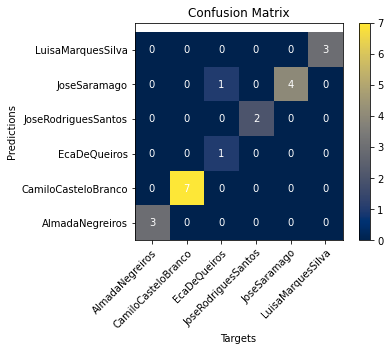

In [26]:
# Function provided by Professor Nuno Antonio on Machine Learning Course

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
confusion_matrix(predict, y_test)

def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

plot_cm(confusion_matrix(predict, y_test), authors)

<a id="section010">
<h3 style='color:#5F6A6E' > 10. Improving Baseline Model</h3>

In order to improve our Baseline Model, the following tests will be made:
    
    Attempt 1: Testing TFIDF vectorizer
    Attempt 2: Testing KNN with diferents k
    Attempt 3: Naive Bayes
    Attempt 4: Logistic Regression
    Attempt 5: Multilayer Perceptron - ANN

<a id="section011">
<h3 style='color:#5F6A6E' > 11. Attempt 1: Testing TFIDF vectorizer</h3>

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv1 = TfidfVectorizer(max_df=0.8)
X1 = cv1.fit_transform(X_train['Text'])
modelknn1 = KNeighborsClassifier(n_neighbors = 5, metric='cosine', weights = 'distance')
modelknn1.fit(X1,y_train)
print(X1.shape)
test1 = cv1.transform(test_sentences)
predict1=modelknn1.predict(test1)
print(classification_report(predict1, y_test, target_names = authors))

(42, 87919)
                     precision    recall  f1-score   support

    AlmadaNegreiros       1.00      1.00      1.00         3
CamiloCasteloBranco       1.00      0.88      0.93         8
       EcaDeQueiros       0.00      0.00      0.00         0
JoseRodriguesSantos       1.00      0.40      0.57         5
       JoseSaramago       1.00      0.80      0.89         5
  LuisaMarquesSilva       0.00      0.00      0.00         0

           accuracy                           0.76        21
          macro avg       0.67      0.51      0.57        21
       weighted avg       1.00      0.76      0.85        21



C:\Users\Francisco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Francisco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Francisco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Francisco\AppData\Local\Temp\ipykernel_9224\1944878786.py:45: UserWarning: Attempting to set identical bottom == top == 5.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


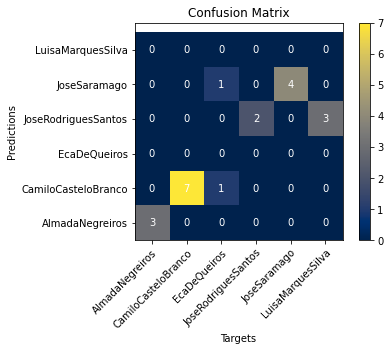

In [28]:
plot_cm(confusion_matrix(predict1, y_test), authors)

The accuracy decreased from 95% to 76%, so we decided to exclude TF-IDF vectorizer from our model.

<a id="section12">
<h3 style='color:#5F6A6E' > 12. Attempt 2: Testing KNN with diferents k</h3>

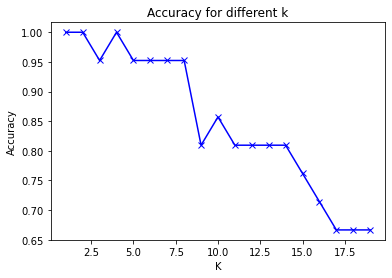

In [29]:
warnings.filterwarnings('ignore') 

KNN_accuracy=[]
K = range(1,20)
for k in K:
    modelknn = KNeighborsClassifier(n_neighbors = k, metric='cosine', weights = 'distance')
    modelknn.fit(X,y_train)
    predict=modelknn.predict(test)
    report=classification_report(predict, y_test, target_names = authors,output_dict=True)
    accuracy=report['accuracy']
    KNN_accuracy.append(accuracy)
    #print (k,accuracy)
plt.plot(K, KNN_accuracy, 'bx-')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy for different k')
plt.show()

We can conclude that using higher k does not improve the model accuracy, especially when using k>10 the accuracy drops significantly as most of the authors have less than 10 texts in our dataset.

Since we have multiple k with 100% accuracy we will run a GridSearchCV to find the best value for k and also the best distancemetric.

In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10],
    'metric': ['cosine','euclidean','manhattan'],
    'weights': ['distance']
}

clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5,
                           scoring='accuracy')
clf.fit(X,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['cosine', 'euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'weights': ['distance']},
             scoring='accuracy')

In [31]:
print(clf.best_params_)

{'metric': 'cosine', 'n_neighbors': 1, 'weights': 'distance'}


<a id="section13">
<h3 style='color:#5F6A6E' > 13. Attempt 3: Naive Bayes</h3>

In [32]:
from sklearn.naive_bayes import GaussianNB
modelNB = GaussianNB()
modelNB.fit(X.toarray(),y_train)
predictNB=modelNB.predict(test.toarray())

In [33]:
print(classification_report(predictNB, y_test, target_names = authors))

                     precision    recall  f1-score   support

    AlmadaNegreiros       0.33      1.00      0.50         1
CamiloCasteloBranco       1.00      0.54      0.70        13
       EcaDeQueiros       0.00      0.00      0.00         0
JoseRodriguesSantos       1.00      1.00      1.00         2
       JoseSaramago       1.00      0.80      0.89         5
  LuisaMarquesSilva       0.00      0.00      0.00         0

           accuracy                           0.67        21
          macro avg       0.56      0.56      0.51        21
       weighted avg       0.97      0.67      0.76        21



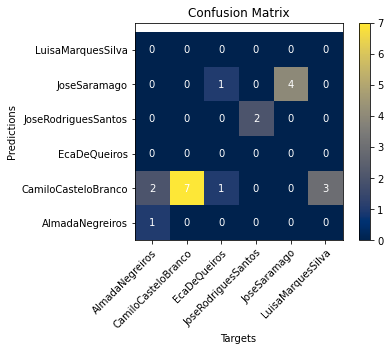

In [34]:
plot_cm(confusion_matrix(predictNB, y_test), authors)

As per the classification report this model has an accuracy of 67%, which is lower than
the KNN (k=5).

<a id="section14">
<h3 style='color:#5F6A6E' > 14. Attempt 4: Logistic Regression</h3>

In [35]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0, multi_class='multinomial',max_iter=1000)
lr.fit(X,y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0)

In [36]:
lr_predictions = lr.predict(test)
lr_predictions

array(['JoseSaramago', 'CamiloCasteloBranco', 'LuisaMarquesSilva',
       'CamiloCasteloBranco', 'JoseSaramago', 'LuisaMarquesSilva',
       'JoseSaramago', 'LuisaMarquesSilva', 'JoseSaramago',
       'JoseRodriguesSantos', 'AlmadaNegreiros', 'AlmadaNegreiros',
       'CamiloCasteloBranco', 'AlmadaNegreiros', 'CamiloCasteloBranco',
       'JoseSaramago', 'AlmadaNegreiros', 'CamiloCasteloBranco',
       'CamiloCasteloBranco', 'AlmadaNegreiros', 'JoseRodriguesSantos'],
      dtype=object)

In [37]:
lr.predict_proba(test)

array([[1.90701714e-03, 3.50273926e-02, 5.22077516e-03, 4.19145529e-02,
        8.76892367e-01, 3.90378955e-02],
       [7.01726778e-04, 9.95111487e-01, 6.18263963e-04, 2.85520817e-04,
        2.69420308e-03, 5.88798209e-04],
       [2.52474315e-01, 2.29527265e-02, 6.85649680e-04, 7.60207727e-04,
        1.32477848e-02, 7.09879316e-01],
       [2.34804378e-04, 9.97928711e-01, 5.93983306e-04, 1.96133367e-04,
        8.90255581e-04, 1.56111886e-04],
       [1.71866905e-04, 2.18101008e-03, 7.90879665e-04, 9.29854627e-03,
        9.86205782e-01, 1.35191546e-03],
       [1.44181714e-01, 1.19002201e-02, 5.40064395e-04, 6.77098550e-04,
        1.02436043e-02, 8.32457299e-01],
       [7.77410552e-03, 1.53081242e-01, 1.47154540e-01, 5.07276317e-02,
        6.14278050e-01, 2.69844316e-02],
       [3.85131075e-01, 2.10675361e-02, 6.54762068e-04, 6.56536705e-04,
        1.24198757e-02, 5.80070215e-01],
       [4.91409068e-03, 3.26441976e-02, 2.19033240e-03, 7.58567295e-03,
        9.05652350e-01, 

In [38]:
print(classification_report(lr_predictions, y_test, target_names = authors))

                     precision    recall  f1-score   support

    AlmadaNegreiros       1.00      0.60      0.75         5
CamiloCasteloBranco       0.71      0.83      0.77         6
       EcaDeQueiros       0.00      0.00      0.00         0
JoseRodriguesSantos       1.00      1.00      1.00         2
       JoseSaramago       1.00      0.80      0.89         5
  LuisaMarquesSilva       1.00      1.00      1.00         3

           accuracy                           0.81        21
          macro avg       0.79      0.71      0.73        21
       weighted avg       0.92      0.81      0.85        21



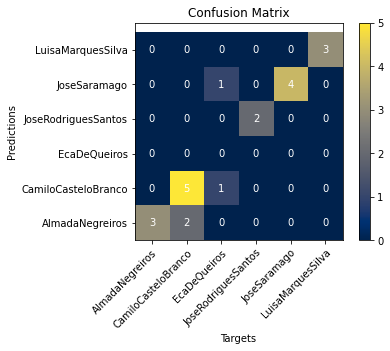

In [39]:
plot_cm(confusion_matrix(lr_predictions, y_test), authors)

This model has high accuracy (81%) however it is not as high as the KNN. Other drawback of this model is that it is more computational expensive, as it takes longer to train than the KNN or Naïve Bayes.

<a id="section15">
<h3 style='color:#5F6A6E' > 15. Attempt 5: Multilayer Perceptron - ANN</h3>

#### Important note: please be aware that the GridSearch on the Multilayer Perceptron - ANN section takes nearly 1-hour to run

In [40]:
from sklearn.neural_network import MLPClassifier

#### Test different number of layers and nodes

In [41]:
warnings.filterwarnings('ignore') 

param_grid = {
    'hidden_layer_sizes': [(10,6),(20,6),(30,6),(40,6),(50,6)],
    'solver': ['adam','lbfgs'],
    'learning_rate': ['adaptive'],
    'activation': ['relu', 'logistic'],
}


clf = GridSearchCV(MLPClassifier(), param_grid, cv=3,
                           scoring='accuracy')
clf.fit(X,y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(),
             param_grid={'activation': ['relu', 'logistic'],
                         'hidden_layer_sizes': [(10, 6), (20, 6), (30, 6),
                                                (40, 6), (50, 6)],
                         'learning_rate': ['adaptive'],
                         'solver': ['adam', 'lbfgs']},
             scoring='accuracy')

In [42]:
print(clf.best_params_)

{'activation': 'logistic', 'hidden_layer_sizes': (50, 6), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


In [43]:
mlp = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(50,6), activation='logistic', random_state=1, learning_rate='adaptive')
mlp.fit(X,y_train)
mlp_predictions = mlp.predict(test)
print(classification_report(mlp_predictions, y_test, target_names = authors))

                     precision    recall  f1-score   support

    AlmadaNegreiros       1.00      0.75      0.86         4
CamiloCasteloBranco       1.00      1.00      1.00         7
       EcaDeQueiros       0.50      1.00      0.67         1
JoseRodriguesSantos       1.00      1.00      1.00         2
       JoseSaramago       1.00      1.00      1.00         4
  LuisaMarquesSilva       1.00      1.00      1.00         3

           accuracy                           0.95        21
          macro avg       0.92      0.96      0.92        21
       weighted avg       0.98      0.95      0.96        21



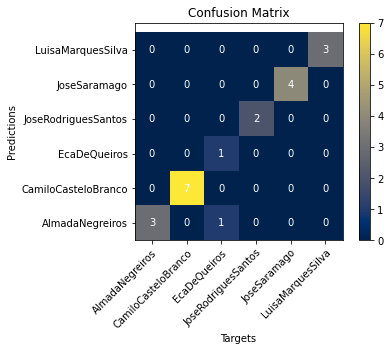

In [44]:
plot_cm(confusion_matrix(mlp_predictions, y_test), authors)

The accuracy is the same of the Baseline Model: 95%. We will discuss this result in the next chapters.

<a id="section16">
<h3 style='color:#5F6A6E' > 16. Final Model</h3>

Based on our experiments and comparing them with our baseline, we were not capable of improving our model performance by changing the preprocessing and feature engineering methods. <br>
However, we found that changing the model from KNN (k=5) to KNN (k=1) (attempt 2) or to an Artificial Neural Network (attempt 5) can increase our model accuracy. <br>
<br>
The final model we found which maximizes accuracy is the following:<br>

    1. Preprocessing methods: lowercasing; removing punctuation, accents, numerical characters and stop words;
    
    2. Feature engineering: binary Bag of Words;
    
    3. Model: K-Nearest-Neighbors (KNN) with k=1;
    
The predictions results of this model are the following:

In [45]:
modelknn = KNeighborsClassifier(n_neighbors = 1, metric='cosine', weights = 'distance')
modelknn.fit(X,y_train)
predict=modelknn.predict(test)
print(classification_report(predict, y_test, target_names = authors))

                     precision    recall  f1-score   support

    AlmadaNegreiros       1.00      1.00      1.00         3
CamiloCasteloBranco       1.00      1.00      1.00         7
       EcaDeQueiros       1.00      1.00      1.00         2
JoseRodriguesSantos       1.00      1.00      1.00         2
       JoseSaramago       1.00      1.00      1.00         4
  LuisaMarquesSilva       1.00      1.00      1.00         3

           accuracy                           1.00        21
          macro avg       1.00      1.00      1.00        21
       weighted avg       1.00      1.00      1.00        21



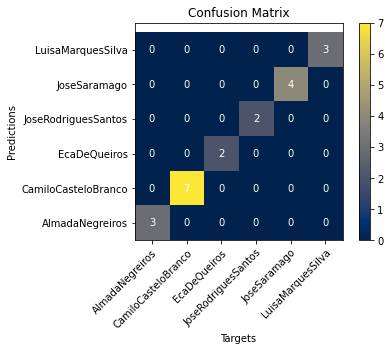

In [46]:
plot_cm(confusion_matrix(predict, y_test), authors)

<a id="section17">
<h3 style='color:#5F6A6E' > 17. Conclusion</h3>

Analyzing our final model (KNN with k=1) we can conclude that when predicting the author of a text, the model bases its prediction with only the nearest text that it has already seen before.

If the dataset was larger, we would be more comfortable in choosing a higher k, but considering that on our dataset is relatively small and one of the authors only has 5 texts, to consider a higher k would not be reasonable.

Other model that showed similar results was the ANN. The downside of this model is the time it takes to train. Given the fact that it takes much longer to train and it did not present any performance gains comparing with the KNN, we do not see a valid reason
to choose it over the KNN.